In [14]:
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("../src")
sys.path.append("../data")

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pprint as pp

import sindy_utils
from sindy_data import generate_system_from_dynamics
from dynamics import Exp2D
from dynamics import Lorenz
from dynamics import SimplePendulum

from sindy import SINDy, SINDy_LSQ
from sindy_algorithms import STLSQ
from sindy_libs import PolynomialLibrary, TrigLibrary

In [15]:
def simulate_system(system, init_conditions, t0, tf, steps):
    return generate_system_from_dynamics(
        system.f,
        init_conditions = init_conditions,
        t0=t0,
        tf=tf,
        steps=steps,
        equations=system.equations
    )

In [26]:
lorenz = simulate_system(
    SimplePendulum(),
    (np.pi/2,0),
    0,
    40,
    100000
)

lorenz.show()


initial conditions: (1.5707963267948966, 0)

equations:
(θ)'     = θ_dot
(θ_dot)' = -9.8/2 * sin(θ) - 0.5 * θ_dot



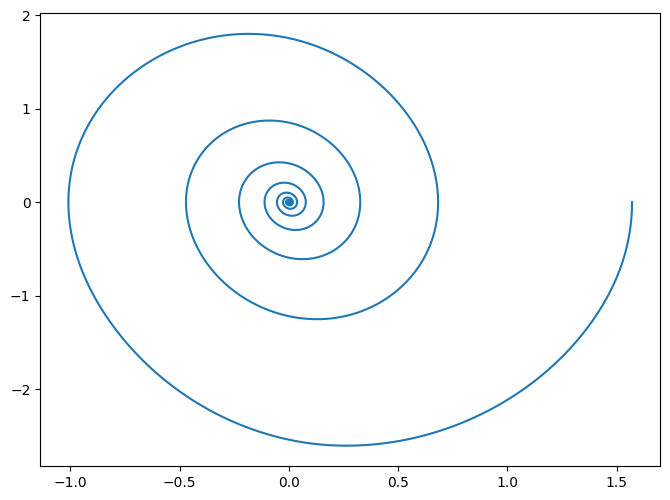

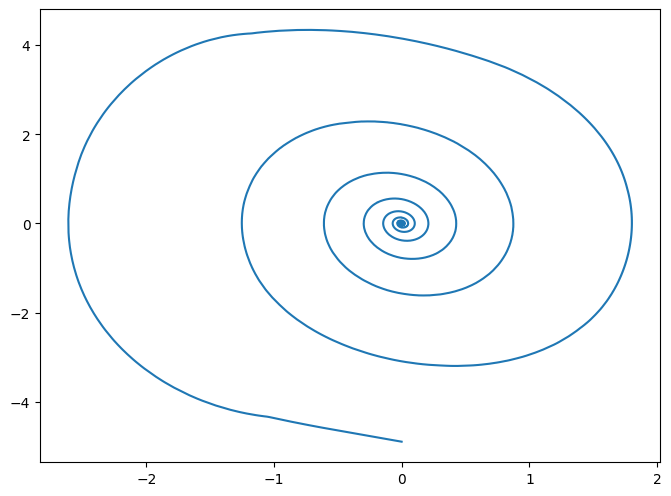

In [30]:
X, X_dot, t = lorenz.time_series()

X_train = sindy_utils.add_noise(X, amount=0)

X_dot_train = sindy_utils.differentiate(X_train,t)
sindy_utils.plot(X_train)
sindy_utils.plot(X_dot_train)

In [31]:
model = SINDy_LSQ(
    libs=[
        PolynomialLibrary(max_degree=2),
        TrigLibrary()
    ],
    feature_names=['x','y','z'],
    algo=STLSQ(threshold=0.3, reg=1)
)

model.fit(X_train, X_dot_train)
lorenz.show()
model.show()


initial conditions: (1.5707963267948966, 0)

equations:
(θ)'     = θ_dot
(θ_dot)' = -9.8/2 * sin(θ) - 0.5 * θ_dot

(x)' = 1.0 y
(y)' = -0.503 y + -4.904 sin(x)


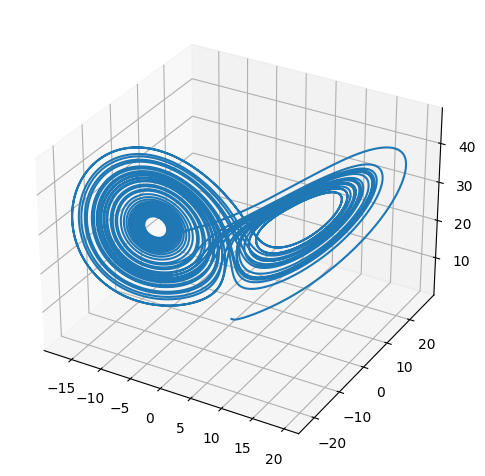

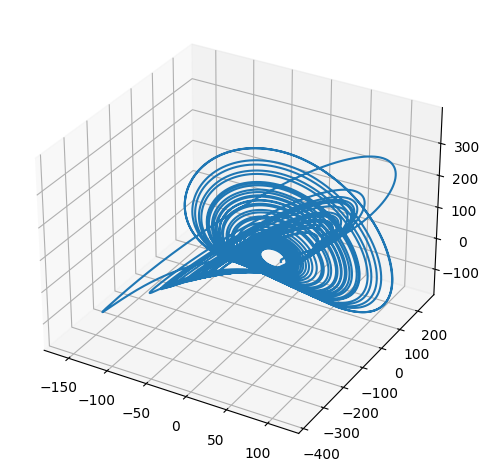

In [6]:
sindy_utils.plot(X)
sindy_utils.plot(X_dot)

In [10]:
model = SINDy(
    input_dim=X.size(),
    libs=[
        PolynomialLibrary(max_degree=2),
        TrigLibrary()
    ],
    feature_names=['x','y','z'],
)

In [11]:
norm_2 = lambda X: torch.linalg.norm(X)

loss_fn = lambda X, X_pred: norm_2(X - X_pred)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [12]:
epochs = 40000

for t in range(epochs):
    
    f_X = model(X)
    loss = loss_fn(X_dot, f_X)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if t % 1000 == 0:
        print(loss)

model.show()

tensor(67420.6250, grad_fn=<CopyBackwards>)
tensor(12572.3184, grad_fn=<CopyBackwards>)
tensor(11131.2256, grad_fn=<CopyBackwards>)
tensor(9882.4893, grad_fn=<CopyBackwards>)
tensor(8696.6865, grad_fn=<CopyBackwards>)
tensor(7545.8130, grad_fn=<CopyBackwards>)
tensor(6449.7603, grad_fn=<CopyBackwards>)
tensor(5431.6294, grad_fn=<CopyBackwards>)
tensor(4531.4165, grad_fn=<CopyBackwards>)
tensor(3813.5847, grad_fn=<CopyBackwards>)
tensor(3339.8350, grad_fn=<CopyBackwards>)
tensor(3089.6196, grad_fn=<CopyBackwards>)
tensor(2940.0613, grad_fn=<CopyBackwards>)
tensor(2788.0139, grad_fn=<CopyBackwards>)
tensor(2616.9951, grad_fn=<CopyBackwards>)
tensor(2437.9612, grad_fn=<CopyBackwards>)
tensor(2258.9062, grad_fn=<CopyBackwards>)
tensor(2082.3643, grad_fn=<CopyBackwards>)
tensor(1907.9358, grad_fn=<CopyBackwards>)
tensor(1734.8566, grad_fn=<CopyBackwards>)
tensor(1562.8440, grad_fn=<CopyBackwards>)
tensor(1391.6444, grad_fn=<CopyBackwards>)
tensor(1221.3000, grad_fn=<CopyBackwards>)
tensor(1

In [63]:
pendulum = simulate_system(
    SimplePendulum(g=9.8, l=4, mu=0),
    (np.pi/2, 0),
    0,
    10,
    10000
)

pendulum.show()


initial conditions: (1.5707963267948966, 0)

equations:
(θ)'     = θ_dot
(θ_dot)' = -9.8/4 * sin(θ) - 0 * θ_dot



In [65]:
X, X_dot, t = pendulum.time_series()

In [69]:
model = SINDy_LSQ(
    libs=[
        PolynomialLibrary(max_degree=2),
        TrigLibrary()
    ],
    feature_names=['θ', 'θ_dot'],
    algo=STLSQ(threshold=0, reg=0)
)

model.fit(X, X_dot)
model.show()

(θ)' = 0.45 1 + 1.0 θ_dot + -0.256 θ^2 + 0.066 θ_dot^2 + -0.664 cos(θ) + 0.182 cos(θ_dot)
(θ_dot)' = 0.214 1 + -0.121 θ^2 + 0.031 θ_dot^2 + -2.45 sin(θ) + -0.316 cos(θ) + 0.085 cos(θ_dot)
